# Workflow - WFP use-case - Integrating seasonal forecast data

## TO DO
* Bias-correct seasonal forecast data: currently, only the raw input data is visualized - Data has to be bias-corrected based on hindcast data before
* Consider visualising SPI for drought prediction, rather than Seasonal forecast anomalies

## Workflow overview

- [1. Open datasets with xarray library](#open_dataset)
    - ERA-interim total precipitation monthly means of daily accumulations
    - Seasonal forecast monthly means of total precipitation accumulation rate
    - Seasonal forecast monthly means total precipitation accumulation anomalies
    - Shapefile containing country or watershed geometries
    
    
- [2. Map the shapefile onto the xarray data objects (rasterize function)](#rasterize)
    - Execute the rasterize function on all loaded raster objects


- [3. Compute the climatologies and calculate ERA-interim anomalies](#anomalies)
    - calculate 1981-2010 climatology from ERAinterim data
    - calculate anomalies based on the climatology
 
 
- [4. Compute the mean per country](#country_mean)
    - Retrieve the mean value of all pixels per country, by using the xarray groupby function
    

- [5. Create a dataframe object that contains all the countries represented by the final data objects](#dataframe)


- [6. Visualize ERA-interim anomalies from 1979-2018](#eraint_vis)


- [7. Visualize ERA-interim anomalies from 2018 together with seasonal forecast anomalies](#seasonal_vis) <br>(all visualizations are based on Python's interactive visualization library Bokeh)
    - Seasonal forecast anomalies are shown as the spread of all 51 ensemble members, the mean of all ensembles members, as well as the 25th- and 95th-percentile



<hr>

## Results - Examples from Mozambique

<img src="./img/bokeh_seasonal_forecast.png" width="45%" align='left'></img><img src="./img/bokeh_eraint_anomalies.png" width="50%" align='right'></img>

<hr>

#### Load required libraries

In [1]:
# allow Jupyter notebooks to access external connection withou HTTPS
import os, ssl
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and
    getattr(ssl, '_create_unverified_context', None)): 
    ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
import glob
import os
import numpy as np
import xarray as xr
import geopandas as gpd
import rasterio
import pandas as pd

In [3]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.layouts import widgetbox
from bokeh.models.widgets import Dropdown
from bokeh.models import Legend
output_notebook()

Loading BokehJS ...

In [4]:
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

### <a id="open_dataset"></a>1. Open datasets with xarray library

#### Open seasonal forecast data (netCDF format) with xarray

In [5]:
# From a NetCDF file, data is read as a xarray Dataset, xarray's multi-dimensional equivalent of a DataFrame.
tp_seasonal_ar = xr.open_dataset('201809_tp_c3s_seasonal_mm.nc')

# convert Total precipitation rate from m / s to mm / day
tp_seasonal_ar_mm = tp_seasonal_ar * 86400000 

#### Open seasonal anomalies (netCDF format) with xarray

In [6]:
xr_dataset = xr.open_dataset('./201809_tp_c3s_seasonal_mma.nc')
tp_seasonal_anomalies_mm = xr_dataset * 86400000 # convert Total precipitation rate from m / s to mm / day

#### Open ERA-interim data (netCDF format) with xarray and concatenate the files

In [7]:
fileList = glob.glob('./eraint_mdfa/*.nc')

j=0
for i in fileList:
    dataset = xr.open_dataset(i)
    dataset_mm = dataset * 1000
    globals()['temp' + str(j)] = dataset_mm.resample(time='M').sum()
    j = j+1

#Concat the previously loaded xarray objects. Resulting object is a xarray.DataArray
eraint_tp = xr.concat([temp2.tp[:,:,:],temp0.tp[:,:,:],temp3.tp[:,:,:], temp1.tp[:,:,:]], dim='time')

#### Open shapefile with geopandas

In [8]:
gdf = gpd.read_file('./ADM00_extr_mask/ADM00_extr_mask.shp')

##### Check the loaded shapefile and plot it

In [9]:
gdf_subset = gdf[gdf['adm0_name'] == 'Japan']
gdf_subset.plot(figsize=(10,30))

##### Plot the shapefile on top of the xarray - dataarray

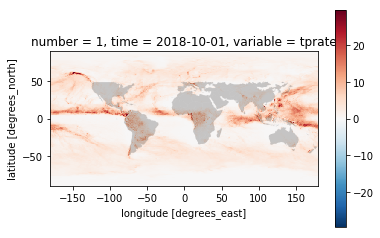

In [10]:
ax = gdf.plot(alpha=0.2, color="black")
tp_seasonal_ar_mm.to_array().isel(number=1, time=1).plot(ax=ax, zorder=-1)

### <a id="rasterize"></a> 2. Map the shapefile onto the data objects

#### Functions to rasterize a shapefile onto a given xarray object

In [11]:
#Function provided by Stephan Hoyer
from rasterio import features

from affine import Affine
def transform_from_latlon(lat, lon):
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    trans = Affine.translation(lon[0], lat[0])
    scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
    return trans * scale

def rasterize(shapes, coords, latitude='latitude', longitude='longitude',
              fill=np.nan, **kwargs):
    """Rasterize a list of (geometry, fill_value) tuples onto the given
    xray coordinates. This only works for 1d latitude and longitude
    arrays.
    """
    transform = transform_from_latlon(coords[latitude], coords[longitude])
    out_shape = (len(coords[latitude]), len(coords[longitude]))
    #requires the features library from rasterio
    raster = features.rasterize(shapes, out_shape=out_shape,
                                fill=fill, transform=transform,dtype=float, **kwargs)
    spatial_coords = {latitude: coords[latitude], longitude: coords[longitude]}
    return xr.DataArray(raster, coords=spatial_coords, dims=(latitude, longitude))

#### Helper function get a dictionary of the shapefile's country names and country id's

In [12]:
world_ids = {k: i for i, k in enumerate(gdf.adm0_name)}

#### Execute the rasterize function on seasonal forecast and ERA-interim data

In [ ]:
%%time
# Seasonal forecast data
shapes = zip(gdf.geometry, range(len(gdf)))
tp_seasonal_ar_mm['countries'] = rasterize(shapes, tp_seasonal_ar_mm.coords, longitude='longitude', latitude='latitude')

In [ ]:
%%time
#ERAinterim total precipitation - Monthly accumulated means - 1979-2018
shapes = zip(gdf.geometry, range(len(gdf)))
eraint_tp['countries'] = rasterize(shapes, eraint_tp.coords, longitude='longitude', latitude='latitude')

In [ ]:
%%time
#Sessonal forecast anomalies
shapes = zip(gdf.geometry, range(len(gdf)))
tp_seasonal_anomalies_mm['countries'] = rasterize(shapes, tp_seasonal_anomalies_mm.coords, longitude='longitude', latitude='latitude')

#### Select a country and plot the rasterized object

In [ ]:
(eraint_tp.countries == world_ids['Mozambique']).plot(figsize=(50,20))

### <a id="anomalies"></a>3. Compute the climatology for ERA-interim time series and calculate anomalies

In [ ]:
# Select the time from 1981-2010 and calculate the mean of all months
climatology_mean_19812010 = eraint_tp[24:384,:,:].groupby('time.month').mean('time')
era_int_anomaly = eraint_tp.groupby('time.month') - climatology_mean_19812010

In [ ]:
%%time
#ERAinterim anomaly
shapes = zip(gdf.geometry, range(len(gdf)))
era_int_anomaly['countries'] = rasterize(shapes, era_int_anomaly.coords, longitude='longitude', latitude='latitude')

### <a id="country_mean"></a> 4. Compute the mean per country based on the xarray groupby function

In [ ]:
tp_seasonal_countries = tp_seasonal_ar_mm.groupby('countries').mean('stacked_latitude_longitude')

In [ ]:
tp_eraint_countries = eraint_tp.groupby('countries').mean('stacked_latitude_longitude')

In [ ]:
eraint_anomaly_countries = era_int_anomaly.groupby('countries').mean('stacked_latitude_longitude')

In [ ]:
tp_seasonal_anomalies_mm_countries = tp_seasonal_anomalies_mm.groupby('countries').mean('stacked_latitude_longitude')

### <a id="dataframe"></a>5. Create a dataframe with countries that are represented in the final data objects

Not all countries are represented, as some countries were too small to rasterized. The initial shapefile has 172 countries and the resulting rasterized object has 151. The resulting dataframe shows the countries that can be represented.

In [ ]:
countries = list(gdf.adm0_name)
countries.append(range(len(countries)))
country_id = list(range(0,171))
zipped = list(zip(country_id,countries))
zipped_df = pd.DataFrame(zipped,columns=['country_id', 'country_name'])

countryVals = tp_eraint_countries.countries

countries_xr = pd.Series(countryVals).to_frame()
countries_xr.columns = ['country_id']
countries_df = pd.merge(countries_xr,zipped_df, on='country_id', how='inner')

### <a id="eraint_vis"></a>6. Visualize ERA-interim precipitation anomalies

In [ ]:
#Plotting function, where positive and negative values are seperated in order to colour them differently in the resulting plot
def f(country):
    country_id = world_ids.get(country)
    eraint_anomaly_country = eraint_anomaly_countries.sel(countries=country_id)
    xVals = eraint_anomaly_country.time.to_dataframe()
    yVals = eraint_anomaly_country.to_dataframe()
    posVals = yVals.where(yVals > 0)
    negVals = yVals.where(yVals < 0)
    p = figure(plot_width=900, plot_height=500, x_axis_type='datetime', title='Monthly anomalies - Total precipitation 1979-2018', x_axis_label='Month', y_axis_label='mm')
    p.vbar(xVals.time, top=negVals.tp, width=100, color='lightsalmon')
    p.vbar(xVals.time, top=posVals.tp, width=100, color="royalblue")
    p.title_location = 'above'
    p.title.text_font_size = '12pt'
    p.title.align = 'center'
    show(p)

select = widgets.Select(
    options=list(countries_df.country_name),
    value='Mozambique',
    description='Country:',
    disabled=False
)

interactive_plot = interactive(f, country=select)
interactive_plot

### <a id="seasonal_vis"></a> 7. Visualize anomalies including six month seasonal forecasts

In [ ]:
from datetime import timedelta

def calculateStats(array):
    xVals_max = array.groupby('time').max(dim=xr.ALL_DIMS)
    xVals_min = array.groupby('time').min(dim=xr.ALL_DIMS)
    xVals_mean = array.groupby('time').mean(dim=xr.ALL_DIMS)
    quant95 = array.quantile(q=0.95,dim='number').to_dataframe()
    quant25 = array.quantile(q=0.25,dim='number').to_dataframe()
    
    df = pd.DataFrame(data = xVals_min.time.values, columns=['time'])
    df['miny'] = xVals_min.tpara.values
    df['meany'] = xVals_mean.tpara.values
    df['maxy'] = xVals_max.tpara.values
    df['quant95'] = quant95.tpara.values
    df['quant25'] = quant25.tpara.values

    return df

def plotData(df, xlist, ylist):
    p = figure(plot_width=900, plot_height=700, x_axis_type='datetime', title='Monthly anomalies - Total precipitation - 2018 + 6 month seasonal forecast', x_axis_label='Month', y_axis_label='mm')
    p.title.align = 'center'
    p.title.text_font_size = '12pt'
    p.title_location = 'above'

    it1 = p.vbar(x=df.time.values, top=df.erainty_bar.values, width=1000000000, color="royalblue")
    it2 = p.line(x=df.time.values, y=df.meany.values, color='mediumblue', line_width=4)
    it3 = p.patch(xlist, ylist, alpha=0.3, color='gainsboro')
    it4 = p.line(x=df.time.values, y=df.quant25.values, color="mediumblue", line_dash='dashed')
    it5 = p.line(x=df.time.values, y=df.quant95.values, color='mediumblue', line_dash='dashed')

    p.xgrid.grid_line_dash = 'dashed'
    p.ygrid.grid_line_dash = 'dashed'
    p.xgrid.grid_line_alpha = 0.5
    p.ygrid.grid_line_alpha = 0.5
    
    legend = Legend(items=[
        ("Anomalies based on 1980-2010 climatology", [it1]),
        ("Mean of ensemble members", [it2]),
        ("Ensemble spread - 6 month seasonal forecast", [it3]),
        ("25th- and 95th percentile", [it4])
    ], location=(515,0))
    p.add_layout(legend, 'below')
    show(p)

def f(country):
    country_id = world_ids.get(country)
    eraint_country = eraint_anomaly_countries.sel(countries=country_id)
    tp_seasonal_country = tp_seasonal_anomalies_mm_countries.sel(countries=country_id)
    
    seasonal_forecast_stats = calculateStats(tp_seasonal_country)

    eraint_xVals = eraint_country.time[468:475].to_dataframe()
    eraint_yVals = eraint_country[468:475].to_dataframe()

    df_extend = eraint_xVals.append(seasonal_forecast_stats, sort=True)
    df_extend['erainty_bar'] = eraint_yVals.reindex(df_extend.time, fill_value=np.nan).tp.values

    x_list = [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, df_extend.time[0], df_extend.time[0], df_extend.time[1],df_extend.time[2],df_extend.time[3],df_extend.time[4],df_extend.time[5], df_extend.time[5], df_extend.time[4], df_extend.time[3], df_extend.time[2], df_extend.time[1]]    
    y_list = [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, df_extend.miny[0],df_extend.maxy[0],df_extend.maxy[1],df_extend.maxy[2],df_extend.maxy[3],df_extend.maxy[4],df_extend.maxy[5], df_extend.miny[5], df_extend.miny[4], df_extend.miny[3],df_extend.miny[2],df_extend.miny[1]]

    plotData(df_extend, x_list, y_list)

    
select = widgets.Select(

    options=list(countries_df.country_name),
    value='Mozambique',
    description='Country:',
    disabled=False
)

interactive_plot = interactive(f, country=select)
interactive_plot